<a href="https://colab.research.google.com/github/Akshaypartha92/Demo/blob/master/benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# csv_to_parquet.py

%matplotlib inline
%reload_ext autoreload
%autoreload 2


from collections import defaultdict
import os
import feather
import numpy as np
import seaborn as sns
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from utils import Timer, MemoryTracker, GC, NotebookStyle

csv_file = '/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/-33.939923_151.175276_Solcast_PT5M.csv'
#parquet_file = '/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/path/to/5minTempData.parquet'
#chunksize = 100_000

df = pd.read_csv(csv_file)
df.to_parquet('/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/output.parquet')

In [22]:
import gc
from multiprocessing import Process, Event, Value
import os
import time
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import psutil


class Timer:
    """Simple util to measure execution time.
    Examples
    --------
    >>> import time
    >>> with Timer() as timer:
    ...     time.sleep(1)
    >>> print(timer)
    00:00:01
    """
    def __init__(self):
        self.start = None
        self.elapsed = None

    def __enter__(self):
        self.start = default_timer()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.elapsed = default_timer() - self.start

    def __str__(self):
        return self.verbose()

    def __float__(self):
        return self.elapsed

    def verbose(self):
        if self.elapsed is None:
            return '<not-measured>'
        return self.format_elapsed_time(self.elapsed)

    @staticmethod
    def format_elapsed_time(value: float):
        return time.strftime('%H:%M:%S', time.gmtime(value))
    
    
class MemoryTrackingProcess(Process):
    """A process that periodically measures the amount of RAM consumed by another process.
    
    This process is stopped as soon as the event is set.
    """
    def __init__(self, pid, event, **kwargs):
        super().__init__()
        self.p = psutil.Process(pid)
        self.event = event
        self.max_mem = Value('f', 0.0)
        
    def run(self):
        mem_usage = []
        while not self.event.is_set():
            info = self.p.memory_info()
            mem_bytes = info.rss
            mem_usage.append(mem_bytes)
            time.sleep(0.05)
        self.max_mem.value = np.max(mem_usage)


class MemoryTracker:
    """A context manager that runs MemoryTrackingProcess in background and collects 
    the information about used memory when the context is exited.
    """
    def __init__(self, pid=None):
        pid = pid or os.getpid()
        self.start_mem = psutil.Process(pid).memory_info().rss
        self.event = Event()
        self.p = MemoryTrackingProcess(pid, self.event)
    
    @property
    def memory(self):
        return self.p.max_mem.value - self.start_mem
    
    def __enter__(self):
        self.p.start()
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.event.set()
        self.p.join()

        
class GC:
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, ext_tb):
        self.collected = gc.collect()
        

class VisualStyle:
    def __init__(self, config, default=None):
        if default is None:
            default = plt.rcParams
        self.default = default.copy()
        self.config = config
        
    def replace(self):
        plt.rcParams = self.config
    
    def override(self, extra=None):
        plt.rcParams.update(self.config)
        if extra is not None:
            plt.rcParams.update(extra)

    def restore(self):
        plt.rcParams = self.default


class NotebookStyle(VisualStyle):
    def __init__(self):
        super().__init__({
            'figure.figsize': (11, 8),
            'axes.titlesize': 20,
            'axes.labelsize': 18,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14,
            'font.size': 16
        })

In [23]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


from collections import defaultdict
import os
import feather
import numpy as np
import seaborn as sns
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [18]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [19]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [25]:
def benchmark(list_of_formats, data_size=1_000_000, n_num=15, n_cat=15, n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset = pd.read_csv(csv_file)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                results['format'] = fmt
                results['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                results['size_mb'] = size_of(filename)
                results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

In [27]:
formats = [('csv', {'index': None})]


In [28]:
csv_results = benchmark(formats, n_rounds=5)

Benchmarking round #1
	generating dataset...
	testing format: csv
Benchmarking round #2
	generating dataset...
	testing format: csv
Benchmarking round #3
	generating dataset...
	testing format: csv
Benchmarking round #4
	generating dataset...
	testing format: csv
Benchmarking round #5
	generating dataset...
	testing format: csv


In [29]:

csv_results.to_feather('/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/baseline5min.feather')
baseline = feather.read_dataframe('/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/baseline5min.feather')

In [30]:
baseline

,format,filename,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time,run_no
0,csv,random.csv,172.5,1.250000,16.300841,496.007812,3.546044,0
1,csv,random.csv,172.5,0.152344,16.300399,208.667969,3.850047,1
2,csv,random.csv,172.5,0.125000,16.227854,215.707031,3.783428,2
3,csv,random.csv,172.5,0.000000,16.237635,193.695312,3.754317,3
4,csv,random.csv,172.5,0.230469,16.233627,169.574219,3.816225,4


In [33]:
formats = [
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('pickle',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [34]:
results = benchmark(formats)

Benchmarking round #1
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #7
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #

In [35]:
results.to_feather('/content/drive/MyDrive/Rexergy/Rexergy interns 2021 S2/1 Data/climate data/Solcast Data/benchmarkingData.feather')

In [36]:
results = pd.concat([baseline, results], axis=0, sort=False)

In [37]:

avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,csv,172.500,0.351562,16.260071,256.730469,3.750012
1,feather,67.910,114.055469,0.580193,989.329492,1.801399
2,hdf,310.442,220.697266,4.575766,556.266016,5.504266
3,parquet,27.690,39.031250,1.141862,809.116602,2.098188
4,pickle,284.840,-66.662305,2.502621,69.732617,1.437575


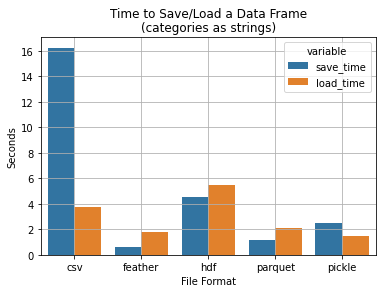

In [38]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)